In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
import pandas as pd

In [2]:
# Step 1: Data Simulation
np.random.seed(42)

# Generate data for Region A (mean differences for realism)
data_region_a = np.random.multivariate_normal(
    mean=[500, 200, 100],  # Mean vector for Region A
    cov=[[400, 100, 50], [100, 300, 30], [50, 30, 200]],  # Covariance matrix
    size=100
)

In [3]:
# Generate data for Region B
data_region_b = np.random.multivariate_normal(
    mean=[520, 220, 120],  # Mean vector for Region B
    cov=[[420, 110, 60], [110, 310, 40], [60, 40, 210]],  # Covariance matrix
    size=100
)

In [4]:
# Combine data into a DataFrame
data = pd.DataFrame(
    np.vstack([data_region_a, data_region_b]),
    columns=["Alimentos", "Transporte", "Entretenimiento"]
)
data["Region"] = ["A"] * 100 + ["B"] * 100

In [5]:
data.head()

,Alimentos,Transporte,Entretenimiento,Region
0,488.242932,195.405274,106.395745,A
1,471.096752,186.355228,89.913731,A
2,478.750529,172.859783,86.728796,A
3,487.606322,200.645710,91.201314,A
4,484.548545,224.753165,75.374062,A


Summary Statistics:
          Alimentos  Transporte  Entretenimiento
Region                                         
A       496.669726  201.285393       100.546040
B       518.429593  221.037400       120.077305


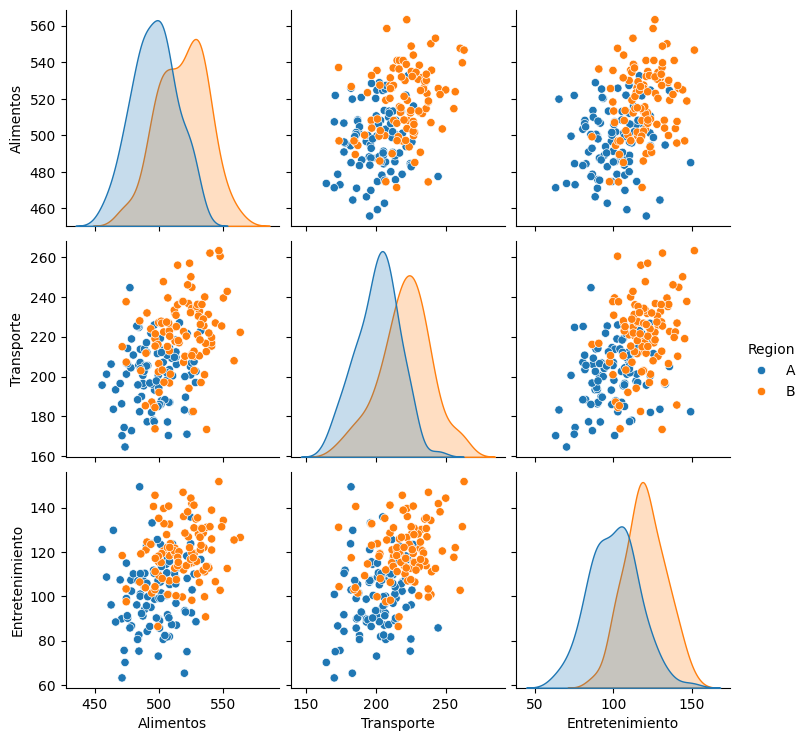

In [6]:
# Step 2: Exploratory Data Analysis
summary = data.groupby("Region").mean()
print("Summary Statistics:\n", summary)

# Pairplot for visualization
import seaborn as sns
sns.pairplot(data, hue="Region")
plt.show()

In [17]:
# Step 3: Hotelling's T2 Test
# Function to calculate Hotelling's T2 statistic
def hotelling_t2_test(group1: np.ndarray, group2: np.ndarray):
    n1, p = group1.shape
    n2, _ = group2.shape

    # Calculate mean vectors
    mean1 = group1.mean(axis=0)
    mean2 = group2.mean(axis=0)

    # Calculate pooled covariance matrix
    s1 = np.cov(group1, rowvar=False)
    s2 = np.cov(group2, rowvar=False)
    s_pooled = ((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)

    # Calculate T2 statistic
    diff_mean = mean1 - mean2
    t2_stat = (n1 * n2 / (n1 + n2)) * diff_mean.T @ np.linalg.inv(s_pooled) @ diff_mean

    # Degrees of freedom
    df1 = p
    df2 = n1 + n2 - p - 1

    # Convert T2 to F-statistic
    f_stat = (t2_stat * df2) / (df1 * (n1 + n2 - 2))
    p_value = 1 - f.cdf(f_stat, df1, df2)

    return t2_stat, f_stat, p_value

In [8]:
# Perform Hotelling's T2 test
group_a = data[data["Region"] == "A"][["Alimentos", "Transporte", "Entretenimiento"]].values
group_b = data[data["Region"] == "B"][["Alimentos", "Transporte", "Entretenimiento"]].values

t2_stat, f_stat, p_value = hotelling_t2_test(group_a, group_b)
print(f"Hotelling's T2 Statistic: {t2_stat}")
print(f"F-Statistic: {f_stat}")
print(f"P-Value: {p_value}")

Hotelling's T2 Statistic: 168.50473737811367
F-Statistic: 55.600889774596425
P-Value: 1.1102230246251565e-16


In [35]:
from matplotlib.patches import Ellipse

def plot_confidence_ellipse(mean_diff, cov, ax, n_std=2.0):
    """
    Plots a confidence ellipse for a bivariate distribution.

    Parameters:
    - mean_diff: Array of mean differences (length 2).
    - cov: Covariance matrix (2x2).
    - ax: Matplotlib Axes object to draw the ellipse.
    - n_std: Number of standard deviations for the ellipse.
    """
    # Ensure the covariance matrix is 2x2
    if cov.shape != (2, 2):
        raise ValueError("Covariance matrix must be 2x2 for a bivariate ellipse.")

    # Eigen decomposition for ellipse parameters
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # Calculate angle and width/height of ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)

    # Create and add the ellipse to the plot
    ellipse = Ellipse(xy=mean_diff, width=width, height=height, angle=angle,
                      edgecolor='red', facecolor='none')
    ax.add_patch(ellipse)

    print("Angulo = {} \nValoresP = {} \nVectoresP = {}".format(angle, eigvals, eigvecs))


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
n1, p = group_a.shape
n2, _ = group_b.shape

# Calculate mean vectors
mean1 = group_a.mean(axis=0)
mean2 = group_b.mean(axis=0)
diff_mean = mean1 - mean2

# Calculate pooled covariance matrix
s1 = np.cov(group_a, rowvar=False)
s2 = np.cov(group_b, rowvar=False)
pooled_cov = ((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)

NameError: name 'group_a' is not defined

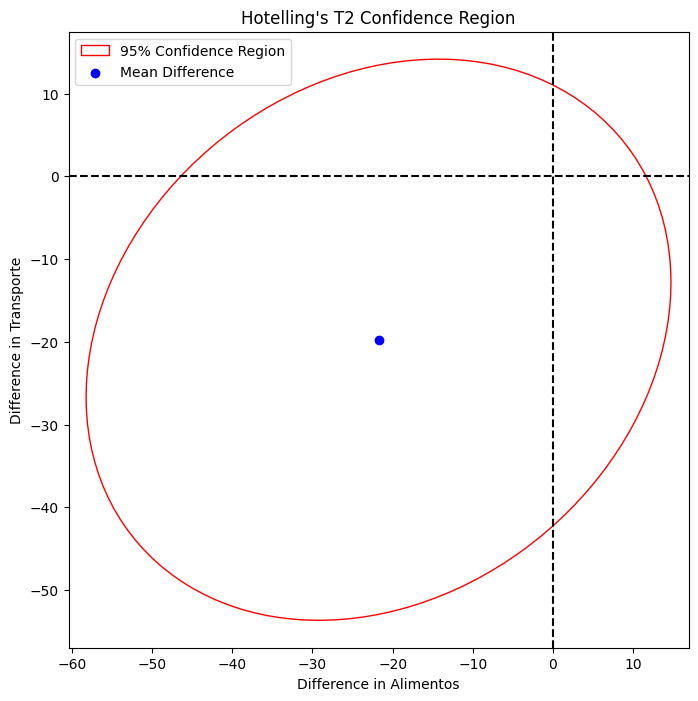

In [11]:
# Reduce to the first two variables (for plotting in 2D)
mean_diff_2d = diff_mean[:2]
pooled_cov_2d = pooled_cov[:2, :2]

# Plot confidence region
fig, ax = plt.subplots(figsize=(8, 8))
plot_confidence_ellipse(mean_diff_2d, pooled_cov_2d, ax, n_std=2.0)
ax.scatter(mean_diff_2d[0], mean_diff_2d[1], color='blue', label='Mean Difference')
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')

# Labels and legend
ax.set_xlabel('Difference in Alimentos')
ax.set_ylabel('Difference in Transporte')
ax.legend(['95% Confidence Region', 'Mean Difference'])
plt.title("Hotelling's T2 Confidence Region")
plt.show()

# Punto 1.d Parcial

In [5]:
df = pd.read_csv("/content/drive/MyDrive/RSTUDIO_/Diseño_Experimentos/Parcial1/Rendimiento_Acad_mico_Dataset.csv")

In [6]:
df.columns[:-1].tolist()

['Puntaje_Matematicas', 'Puntaje_Ciencias', 'Puntaje_Lenguaje']

In [20]:
dfa = df.loc[df['Metodo'] == 'A', df.columns[:-1].tolist()]
dfb = df.loc[df['Metodo'] == 'B', df.columns[:-1].tolist()]


In [21]:
n1, p = dfa.shape
n2, _ = dfb.shape

# Calculate mean vectors
mean1 = dfa.mean(axis=0)
mean2 = dfb.mean(axis=0)
diff_mean = mean1 - mean2

# Calculate pooled covariance matrix
s1 = np.cov(dfa, rowvar=False)
s2 = np.cov(dfb, rowvar=False)
pooled_cov = ((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)

In [22]:
display(mean1,mean2)

,0
Puntaje_Matematicas,84.903966
Puntaje_Ciencias,78.360033
Puntaje_Lenguaje,80.099935


,0
Puntaje_Matematicas,79.061520
Puntaje_Ciencias,74.403886
Puntaje_Lenguaje,77.430446


# Contraste de hipotesis

In [23]:
hotelling_t2_test(dfa, dfb)

(162.2555443201827, 52.98140222699843, 1.1102230246251565e-16)

In [24]:
mean_diff_2d
pooled_cov_2d

array([[8.36762354, 0.0812033 ],
       [0.0812033 , 4.64534106]])

Angulo = -158.49021268387818 
ValoresP = [8.36896806 5.32679824] 
VectoresP = [[-0.93035495  0.36666016]
 [-0.36666016 -0.93035495]]


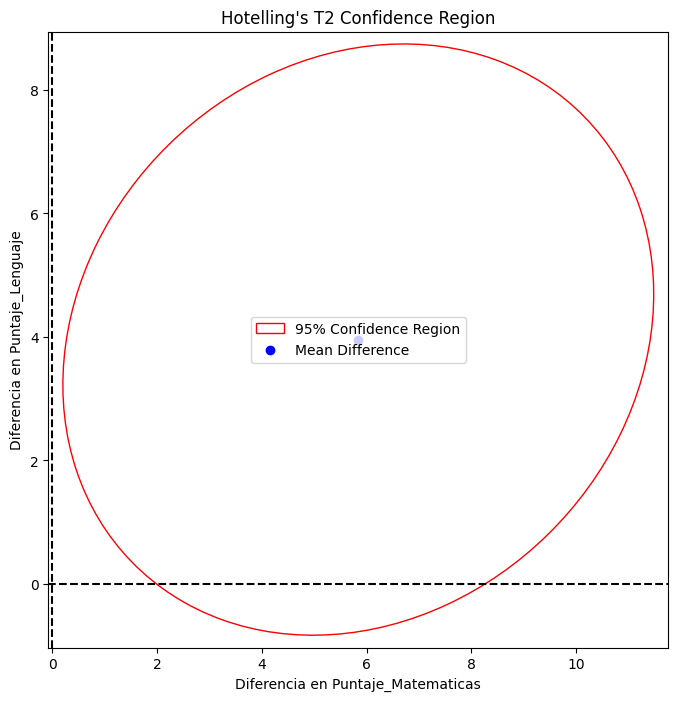

In [36]:
# Reduce to the first two variables (for plotting in 2D)
mean_diff_2d = diff_mean[:2].to_numpy()
pooled_cov_2d = pooled_cov[:2, :2]

# Plot confidence region
fig, ax = plt.subplots(figsize=(8, 8))
plot_confidence_ellipse(mean_diff_2d, pooled_cov_2d, ax, n_std=2.0)
ax.scatter(mean_diff_2d[0], mean_diff_2d[1], color='blue', label='Mean Difference')
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')

# Labels and legend
ax.set_xlabel('Diferencia en Puntaje_Matematicas')
ax.set_ylabel('Diferencia en Puntaje_Lenguaje')
ax.legend(['95% Confidence Region', 'Mean Difference'])
plt.title("Hotelling's T2 Confidence Region")
plt.show()